## DeepSynergy

Author: Kristina Preuer

This Keras script shows how DeepSynergy was evaluated in one cross validation run (executed 5 times - looping over test folds). In this examples fold 0 is used for testing. The script uses 60% of the data  for training (folds 2, 3, 4) and 20% for validation (fold 1). The parameters are loaded with a separate text file (hyperparameters). Validation loss was used to determine the early stopping parameter. After hyperparameter selection the training and validation data was combined (80% = folds 1, 2, 3, 4) and the remaining 20% (fold 0) of the data were used for testing.

The original work was done accordingly with binet (https://github.com/bioinf-jku/binet/tree/master/binet). 

In [1]:
import os, sys

import pandas as pd
import numpy as np
import pickle
import gzip

import matplotlib.pyplot as plt

os.environ["CUDA_VISIBLE_DEVICES"]="3" #specify GPU 
from tensorflow import keras as K
import tensorflow as tf
from tensorflow.keras import backend
from tensorflow.compat.v1.keras.backend import set_session
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

2022-03-19 12:19:57.651022: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


#### Define parameters for this cross-validation run

In [5]:
hyperparameter_file = 'hyperparameters' # textfile which contains the hyperparameters of the model
data_file = '/home/nidhi/Documents/freelancing/DeepSynergy/data/data_test_fold0_tanh.p.gz' # pickle file which contains the data (produced with normalize.ipynb)

#### Define smoothing functions for early stopping parameter

In [6]:
def moving_average(a, n=3):
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

#### Load parameters defining the model

In [7]:
exec(open(hyperparameter_file).read()) 

#### Load data 
tr = 60% of data for training during hyperparameter selection <br>
val = 20% of data for validation during hyperparameter selection

train = tr + val = 80% of data for training during final testing <br>
test = remaining left out 20% of data for unbiased testing 

splitting and normalization was done with normalize.ipynb

In [8]:
file = gzip.open(data_file, 'rb')
X_tr, X_val, X_train, X_test, y_tr, y_val, y_train, y_test = pickle.load(file)
file.close()

#### run set

In [9]:
config = tf.compat.v1.ConfigProto(
         allow_soft_placement=True,
         #gpu_options = tf.GPUOptions(allow_growth=True)
        # gpu_options = tf.compat.v1.GPUOptions(allow_growth = True)
        )

config.gpu_options.allow_growth = True

In [10]:

#set_session(tf.compat.v1.Session()(config=config))

from tensorflow.compat.v1 import InteractiveSession
session = InteractiveSession(config=config)



2022-03-19 12:23:53.801607: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-03-19 12:23:53.999885: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2022-03-19 12:23:54.025743: E tensorflow/stream_executor/cuda/cuda_driver.cc:328] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-03-19 12:23:54.025804: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: Olympias
2022-03-19 12:23:54.025818: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: Olympias
2022-03-19 12:23:54.092101: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported 

In [11]:
model = Sequential()
for i in range(len(layers)):
    if i==0:
        model.add(Dense(layers[i], input_shape=(X_tr.shape[1],), activation=act_func, 
                        kernel_initializer='he_normal'))
        model.add(Dropout(float(input_dropout)))
    elif i==len(layers)-1:
        model.add(Dense(layers[i], activation='linear', kernel_initializer="he_normal"))
    else:
        model.add(Dense(layers[i], activation=act_func, kernel_initializer="he_normal"))
        model.add(Dropout(float(dropout)))
    model.compile(loss='mean_squared_error', optimizer=K.optimizers.SGD(lr=float(eta), momentum=0.5))

/home/nidhi/miniconda3/lib/python3.8/site-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


#### run model for hyperparameter selection

In [16]:
print(X_tr.shape)
print(y_tr.shape)

(27768, 8846)
(27768,)


In [17]:
hist = model.fit(X_tr, y_tr, epochs=2, shuffle=True, batch_size=64, validation_data=(X_val, y_val))
val_loss = hist.history['val_loss']
model.reset_states()

Epoch 1/2
434/434 [==============================] - 116s 267ms/step - loss: 447.9239 - val_loss: 370.4399
Epoch 2/2
434/434 [==============================] - 117s 269ms/step - loss: 430.8977 - val_loss: 362.4108


#### smooth validation loss for early stopping parameter determination

In [27]:
hist.history

{'loss': [404.6344299316406, 393.7026672363281],
 'val_loss': [335.1915588378906, 333.9391174316406]}

In [23]:
average_over = 2 #was 15 earlier. We only ran 2 epochs. So, threw error.
mov_av = moving_average(np.array(val_loss), average_over)
print(mov_av)
smooth_val_loss = np.pad(mov_av, int(average_over/2), mode='edge')
epo = np.argmin(smooth_val_loss)
print(smooth_val_loss)
print(epo)

[366.42536926]
[366.42536926 366.42536926 366.42536926]
0


#### determine model performance for methods comparison 

In [25]:
hist = model.fit(X_train, y_train, epochs=2, shuffle=True, batch_size=64, validation_data=(X_test, y_test))
test_loss = hist.history['val_loss']

2022-03-19 12:49:18.175140: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1309066464 exceeds 10% of free system memory.


Epoch 1/2
579/579 [==============================] - 149s 257ms/step - loss: 404.6344 - val_loss: 335.1916
Epoch 2/2
579/579 [==============================] - 151s 261ms/step - loss: 393.7027 - val_loss: 333.9391


#### plot performance 

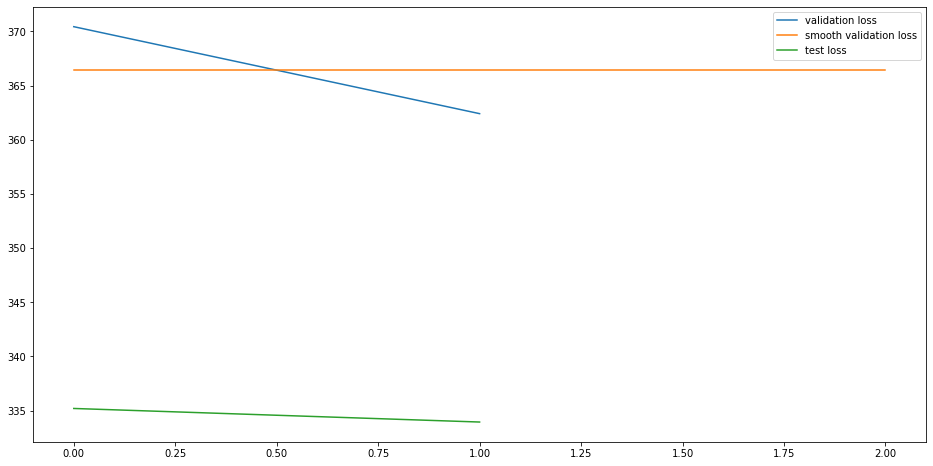

In [26]:
fig, ax = plt.subplots(figsize=(16,8))
ax.plot(val_loss, label='validation loss')
ax.plot(smooth_val_loss, label='smooth validation loss')
ax.plot(test_loss, label='test loss')
ax.legend()
plt.show()